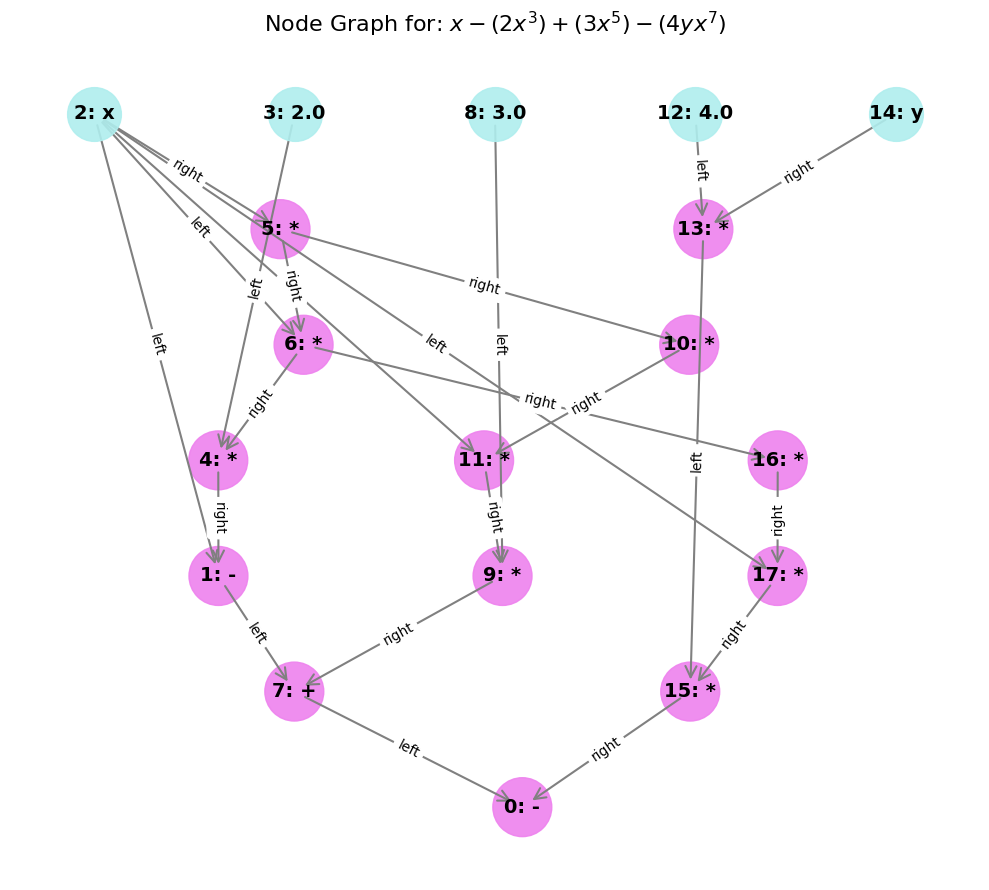

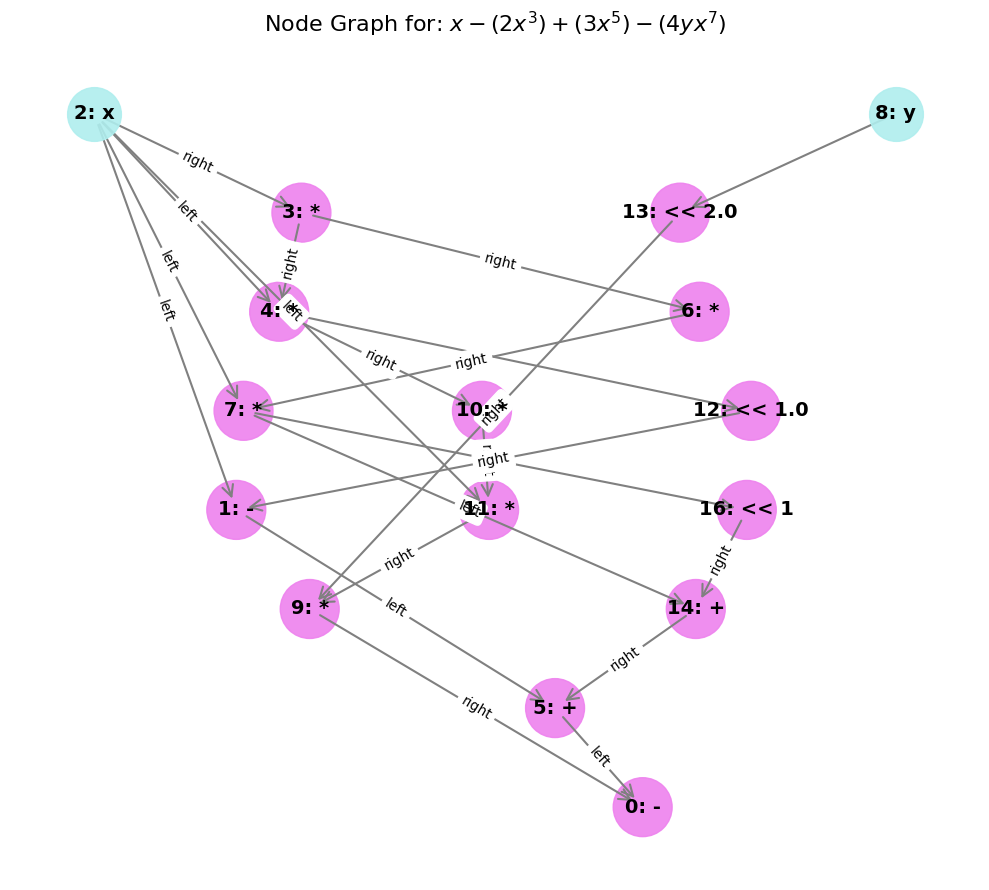

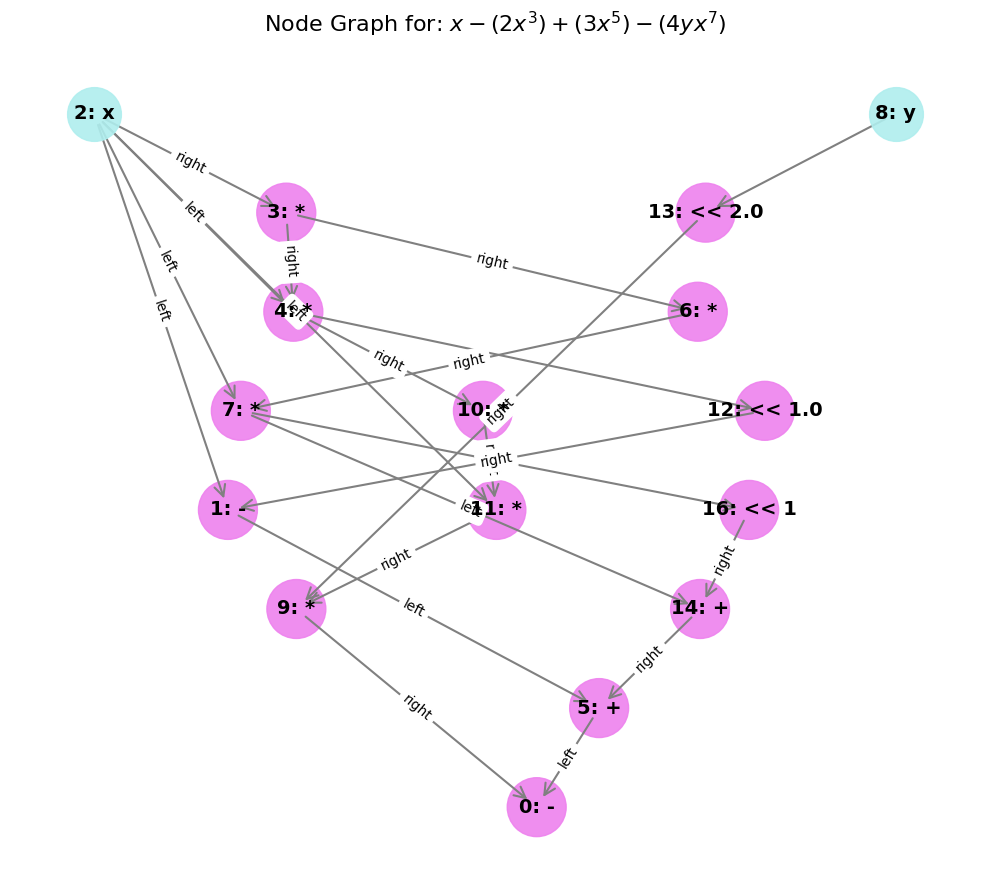

Possible combos:  [[0], [1], [3], [4], [5], [6], [7], [9], [10], [11], [14], [1, 5], [14, 5]]
DSP Solutions:  [[0], [1], [3], [4], [6], [7], [9], [10], [11], [14, 5]]
Number of DSP Blocks:  10
{2: 0, 8: 0, 3: 1, 13: 1, 4: 2, 6: 2, 10: 3, 12: 3, 7: 3, 11: 4, 1: 4, 16: 4, 9: 5, 14: 5, 5: 6, 0: 7}


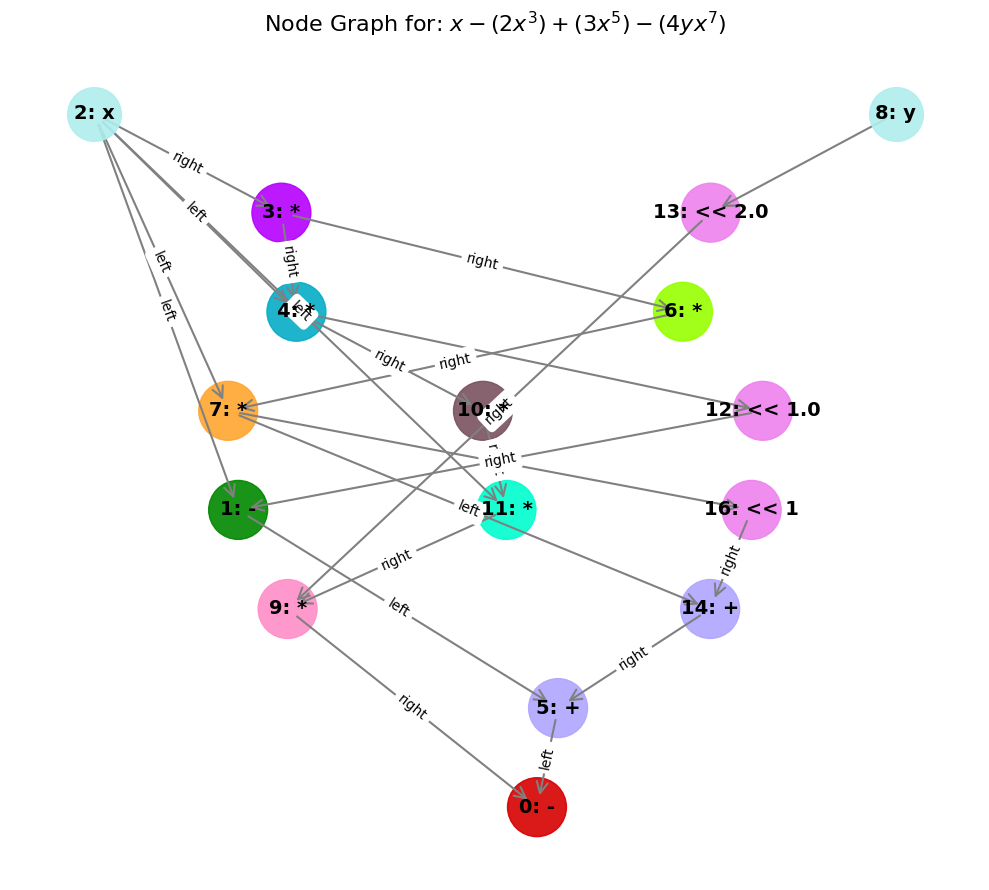

-------------------------


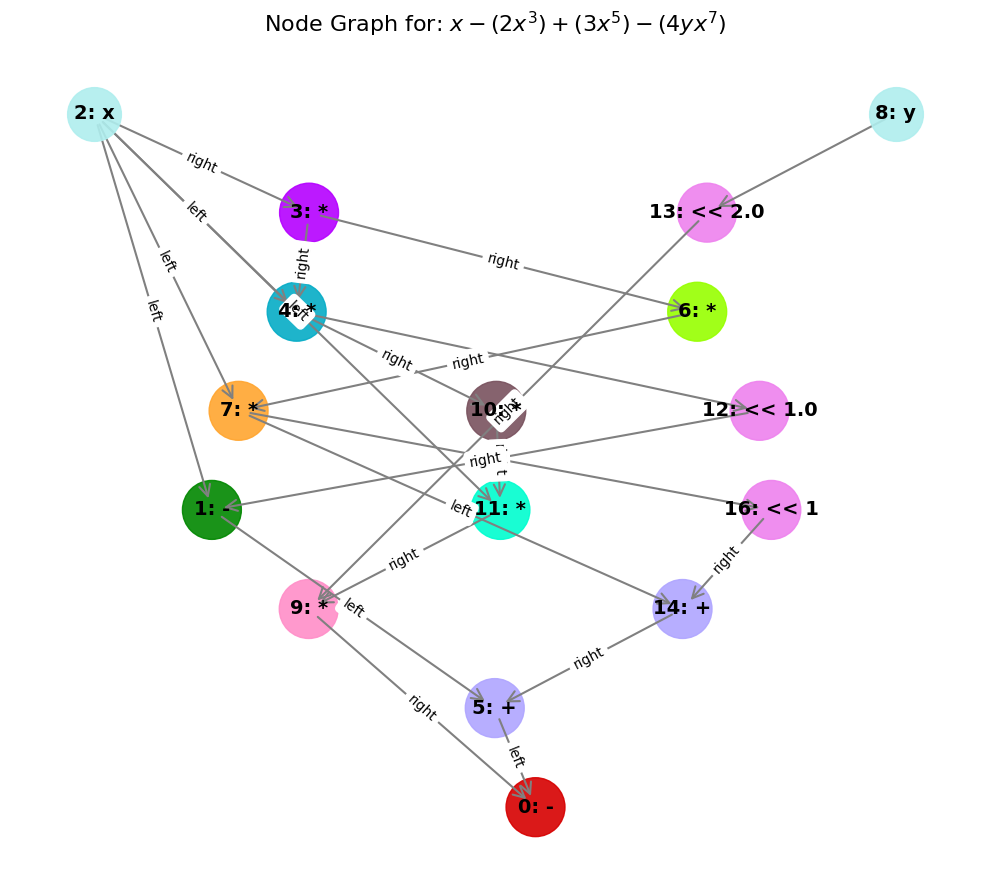

SPLIT HERE----------------------


In [16]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
import numpy as np
import random
from copy import deepcopy
from itertools import product
import pulp as pu
import re
import seaborn as sns
import colorcet as cc
import matplotlib.colors as mcolors
import math


class PolynomialTerm:
    def __hash__(self):
        return hash(str(self))
    
    def __str__(self):
        return str(self.value)
    
    def is_number(self):
        return False
        
    def is_symbol(self):
        return False
    
    def could_extract_minus_sign(self):
        return False
    
    def __repr__(self):
        return str(self)
    
    def __hash__(self):
        return hash(str(self))  
    
    def __eq__(self, other):
        if not isinstance(other, PolynomialTerm):
            return False
        return str(self) == str(other)  

class Variable(PolynomialTerm):
    def __init__(self, value):
        self.value = value
        
    def is_symbol(self):
        return True
    
    def __pow__(self, exponent):
        if isinstance(exponent, Constant):
            return Power(self, exponent)
        elif isinstance(exponent, (int, float)):
            return Power(self, Constant(exponent))
        
    def __hash__(self):
        return hash(self.value)
    
    def __eq__(self, other):
        if not isinstance(other, Variable):
            return False
        return self.value == other.value
    
    def __lt__(self, other):
        return self.value < other.value
    
    def __le__(self, other):
        return self.value <= other.value
    
    def __gt__(self, other):
        return self.value > other.value
    
    def __ge__(self, other):
        return self.value >= other.value
       


class Constant(PolynomialTerm):
    def __init__(self, value):
        self.value = float(value)
        
    def is_number(self):
        return True
        
    @property
    def is_integer(self):
        return self.value == int(self.value)
        
    def __gt__(self, second):
        if isinstance(second, Constant):
            return self.value > second.value
        return self.value > second
        
    def __eq__(self, second):
        if isinstance(second, Constant):
            return self.value == second.value
        return self.value == second
    
    def __hash__(self):
        return hash(self.value)
    
    def __mod__(self, other):
        if isinstance(other, Constant):
            return Constant(self.value % other.value)
        return Constant(self.value % other)

    def __rmod__(self, other):
        return Constant(other % self.value)
    
    def __sub__(self, other):
        if isinstance(other, Constant):
            return Constant(self.value - other.value)
        return Constant(self.value - other)

    def __rsub__(self, other):
        return Constant(other - self.value)
    
    def __pow__(self, exponent):
        if isinstance(exponent, Constant):
            return Constant(self.value ** exponent.value)
        return Constant(self.value ** exponent)
    
    def __floordiv__(self, other):
        if isinstance(other, Constant):
            return Constant(self.value // other.value)
        return Constant(self.value // other)

    def __rfloordiv__(self, other):
        return Constant(other // self.value)


class BinaryOperation(PolynomialTerm):
    def __init__(self, left, right):
        self.left = left
        self.right = right
    
    @property
    def args(self):
        return [self.left, self.right]


class Addition(BinaryOperation):
    def __str__(self):
        return f"{self.left} + {self.right}"
    

class Subtraction(BinaryOperation):
    def __str__(self):
        return f"{self.left} - {self.right}"
    

class Multiplication(BinaryOperation):
    def __str__(self):
        # Adds parentheses around additions and subtractions
        left_str = str(self.left)
        right_str = str(self.right)

        if isinstance(self.left, (Addition, Subtraction)):
            left_str = f"({left_str})"
            
        if isinstance(self.right, (Addition, Subtraction)):
            right_str = f"({right_str})"
            
        return f"{left_str} * {right_str}"
    

class Power(BinaryOperation):
    def __str__(self):
        # Adds parentheses around the base for clarity
        left_str = str(self.left)
        if isinstance(self.left, (Addition, Subtraction, Multiplication)):
            left_str = f"({left_str})"
            
        return f"{left_str}^{self.right}"
    

class UnaryMinus(PolynomialTerm):
    def __init__(self, value):
        self.value = value
    
    def __str__(self):
        term_str = str(self.value)
        if isinstance(self.value, (Addition, Subtraction, Multiplication)):
            term_str = f"({term_str})"
        return f"-{term_str}"
    
    def is_number(self):
        return self.value.is_number() if hasattr(self.value, 'is_number') else False
    
    def could_extract_minus_sign(self):
        return True
    
    @property
    def args(self):
        return [self.value]


class PolynomialParser:
    def __init__(self, expr_string):
        self.expr_tree = None
        self.parse(expr_string)

    
    def parse(self, expr):
        self.expr = expr.replace(' ', '') 
        self.pos = 0
        self.expr_tree = self.parse_expression()
        return self
    
    def current_char(self):
        if self.pos >= len(self.expr):
            return None
        return self.expr[self.pos]
    
    def next_char(self):
        if self.pos >= len(self.expr):
            return None
        return self.expr[self.pos + 1] if self.pos + 1 < len(self.expr) else None

    
    def parse_expression(self):
        if self.current_char() == '-' and self.next_char() and not self.next_char().isdigit():
            self.pos += 1
            # left = Multiplication(Constant(-1.0), self.parse_term())

            left = UnaryMinus(self.parse_term())
            
        else:
            left = self.parse_term()
        
        while self.current_char() in ('+', '-'):
            op = self.current_char()
            self.pos += 1
            right = self.parse_term()
            
            if op == '+':
                left = Addition(left, right)
            else:
                left = Subtraction(left, right)
        
        return left
    
    def parse_term(self):
        left = self.parse_factor()
        
        while self.current_char() == '*':
            self.pos += 1
            right = self.parse_factor()
            left = Multiplication(left, right)
                
        return left
    
    def parse_factor(self):
        char = self.current_char()
        
        # End of expression check
        if char is None:
            return None
        
        #  unary minus
        if char == '-' and self.next_char() and not self.next_char().isdigit():
            self.pos += 1
            return UnaryMinus(self.parse_factor())
        
        # Brackets
        if char == '(':
            self.pos += 1
            expr = self.parse_expression()
            self.pos += 1  # Skip closing bracket
            
            if self.current_char() == '^':
                self.pos += 1
                exponent = self.parse_factor()
                return Power(expr, exponent)
                
            return expr
        
        #  numbers
        if char.isdigit() or (char == '-' and self.next_char() and self.next_char().isdigit()):
            return self.parse_number()
        
        #  variables
        if char.isalpha():
            var = self.parse_variable()
            
            # Check for power after variable
            if self.current_char() == '^':
                self.pos += 1
                exponent = self.parse_factor()
                return Power(var, exponent)

            return var
            
    
    def parse_number(self):
        start_pos = self.pos
        char = self.current_char()
        
        # Handle negative sign only at the beginning
        if char == '-':
            self.pos += 1
            char = self.current_char()
        
        # Parse digits and decimal point
        while char is not None and (char.isdigit() or char == '.'):
            self.pos += 1
            char = self.current_char()
        
        # Create constant
        value = float(self.expr[start_pos:self.pos])
        return Constant(value)
    
    def parse_variable(self):
        start_pos = self.pos
        char = self.current_char()
        
        while char is not None and char.isalnum():
            self.pos += 1
            char = self.current_char()
            
        variable = self.expr[start_pos:self.pos]
        return Variable(variable)
    

    def count(self, node=None):

        if node is None:
            node = self.expr_tree
        
        return self.count_terms(node)
    
    def count_terms(self, node):

        if type(node) in (Addition, Subtraction):
            left_count = self.count_terms(node.left)
            right_count = self.count_terms(node.right)
            return left_count + right_count
        else:
            return 1
        
    def find_variables(self, node = None, variables = None):

        if variables is None:
            variables = set()

        if node is None:
            node = self.expr_tree

        if isinstance(node, Variable):
            variables.add(node)

        elif isinstance(node, (Addition, Subtraction, Multiplication, Power)):
            self.find_variables(node.left, variables)
            self.find_variables(node.right, variables)
            
        elif isinstance(node, UnaryMinus):
            self.find_variables(node.value, variables)
    
        return variables


# -------------------------------------------------------------
# Process the expression recursively
def process_expression(expr, graph, node_id, parent_id=None, top_level=False, expr_to_id=None):

    
    if expr_to_id is None:
        expr_to_id = {}
    
    # Checks if the exact expression has been processed and does not add it if so
    # Uses hash to create a unique key for each expression element
    expr_hash = hash(expr)
    if expr_hash in expr_to_id:
        node_for_expr = expr_to_id[expr_hash]
        if parent_id is not None:
            graph.add_edge(node_for_expr, parent_id)

        return node_id, node_for_expr
    
    #  Addition and Multiplication operations
    if isinstance(expr, (Addition, Multiplication)):
        args = list(expr.args)
        
        if top_level:
            # if top_level = True the first time this function executes, there is a non binary addition as the last addition in the sequence of polynomials
            add_node = node_id
            graph.add_node(add_node, label="+" if isinstance(expr, Addition) else "*", type="operation")
            expr_to_id[expr_hash] = add_node
            node_id += 1
            
            # Process each term in the top-level expression
            for term in args:
                node_id, child_id = process_expression(term, graph, node_id, add_node, top_level=False, expr_to_id=expr_to_id)
            
            if parent_id is not None:
                graph.add_edge(add_node, parent_id)
            return node_id, add_node
        else:
            # Creates a binary tree for addition/multiplication
            if isinstance(expr, Addition,):
                label = "+"
            else:
                label = "*"
                
            if len(args) > 0:
                left_expr = args[0]
                node_id, left_id = process_expression(left_expr, graph, node_id, top_level=False, expr_to_id=expr_to_id)
        
                for i in range(1, len(args)):
                    expr_branch = args[i]
                    
                    # if isinstance(expr, Addition) and expr_branch.could_extract_minus_sign():
                    #     # For addition with negative term, create a subtraction node instead
                    #     parent_node = node_id
                    #     graph.add_node(parent_node, label="-", type="operation")
                    #     expr_to_id[expr_hash] = parent_node
                    #     node_id += 1
                        
                    #     # Connect to the parent node if exists
                    #     if parent_id is not None:
                    #         graph.add_edge(parent_node, parent_id)
                    #         parent_id = parent_node
                        
                    #     # Left branch is the result so far
                    #     graph.add_edge(left_id, parent_node, label='left')
                        
                    #     # Right branch is the term without the negative sign
                    #     if isinstance(expr_branch, UnaryMinus):
                    #         term_without_minus = expr_branch.value
                    #     # else:
                    #     #     term_without_minus = expr_branch 
                            
                    #     node_id, right_id = process_expression(term_without_minus, graph, node_id, top_level=False, expr_to_id=expr_to_id)
                    #     graph.add_edge(right_id, parent_node, label='right')
                    # else:
                        # Standard addition or multiplication node
                    parent_node = node_id
                    graph.add_node(parent_node, label=label, type="operation")
                    expr_to_id[expr_hash] = parent_node
                    node_id += 1
                    
                    # Connect to the parent node if exists
                    if parent_id is not None:
                        graph.add_edge(parent_node, parent_id)
                        parent_id = parent_node
                    
                    # Left branch is the result so far
                    graph.add_edge(left_id, parent_node, label='left')
                    
                    # Right branch is the current term
                    node_id, right_id = process_expression(expr_branch, graph, node_id, top_level=False, expr_to_id=expr_to_id)
                    graph.add_edge(right_id, parent_node, label='right')
                    
                    left_id = parent_node  # for chaining operations
                
                return node_id, left_id


    # Power operation
    elif isinstance(expr, Power):
        base, exp = expr.args
        if hasattr(exp, 'is_integer') and exp.is_integer and exp > 1:
            return convert_power_to_multiplication(expr, base, exp, graph, node_id, parent_id, expr_to_id)

            
    #  variables
    elif isinstance(expr, Variable) or hasattr(expr, 'is_symbol') and expr.is_symbol():
        curr_id = node_id
        graph.add_node(curr_id, label=str(expr), type="value")
        expr_to_id[expr_hash] = curr_id
        node_id += 1
        if parent_id is not None:
            graph.add_edge(curr_id, parent_id)
        return node_id, curr_id
    
    #  constants
    elif hasattr(expr, 'is_number') and expr.is_number():
        curr_id = node_id
        # Display negative numbers directly with the negative sign
        graph.add_node(curr_id, label=str(expr), type="value")
        expr_to_id[expr_hash] = curr_id
        node_id += 1
        if parent_id is not None:
            graph.add_edge(curr_id, parent_id)
        return node_id, curr_id
    
    #  unary minus
    elif isinstance(expr, UnaryMinus):
        curr_id = node_id
        graph.add_node(curr_id, label="-", type="operation")
        expr_to_id[expr_hash] = curr_id
        node_id += 1
        
        if parent_id is not None:
            graph.add_edge(curr_id, parent_id)
        
        # Process the term inside the unary minus
        node_id, term_id = process_expression(expr.value, graph, node_id, curr_id, top_level=False, expr_to_id=expr_to_id)
        
        return node_id, curr_id
    
    #  subtraction
    elif isinstance(expr, Subtraction):
        sub_node = node_id
        graph.add_node(sub_node, label="-", type="operation")
        expr_to_id[expr_hash] = sub_node
        node_id += 1
        
        if parent_id is not None:
            graph.add_edge(sub_node, parent_id)
        
        # Process left and right terms
        node_id, left_id = process_expression(expr.left, graph, node_id, sub_node, top_level=False, expr_to_id=expr_to_id)
        graph.add_edge(left_id, sub_node, label='left')
        
        node_id, right_id = process_expression(expr.right, graph, node_id, sub_node, top_level=False, expr_to_id=expr_to_id)
        graph.add_edge(right_id, sub_node, label='right')
        
        return node_id, sub_node


def convert_power_to_multiplication(expr, base, exp, graph, node_id, parent_id, expr_to_id):
    expr_hash = hash(expr)
    if expr_hash in expr_to_id:
        existing_node_id = expr_to_id[expr_hash]
        if parent_id is not None:
            graph.add_edge(existing_node_id, parent_id)
        return node_id, existing_node_id

    # Handle base cases
    if exp == 1:
        return process_expression(base, graph, node_id, parent_id, top_level=False, expr_to_id=expr_to_id)

    if exp == 2:
        node_id, base_id = process_expression(base, graph, node_id, top_level=False, expr_to_id=expr_to_id)
        mul_node = node_id
        graph.add_node(mul_node, label="*", type="operation")
        expr_to_id[expr_hash] = mul_node
        node_id += 1
        graph.add_edge(base_id, mul_node, label='left')
        graph.add_edge(base_id, mul_node, label='right')
        if parent_id is not None:
            graph.add_edge(mul_node, parent_id)
        return node_id, mul_node

    # For larger exponents, use exponentiation by squaring
    if exp % 2 == 0:
        left_exp = right_exp = exp // 2
    else:
        left_exp = 1
        right_exp = exp - 1

    # Build left subtree
    left_expr = base ** left_exp
    if hash(left_expr) in expr_to_id:
        left_id = expr_to_id[hash(left_expr)]
    else:
        node_id, left_id = convert_power_to_multiplication(left_expr, base, left_exp, graph, node_id, None, expr_to_id)

    # Build right subtree
    right_expr = base ** right_exp
    if hash(right_expr) in expr_to_id:
        right_id = expr_to_id[hash(right_expr)]
    else:
        node_id, right_id = convert_power_to_multiplication(right_expr, base, right_exp, graph, node_id, None, expr_to_id)

    # Create multiplication node
    mul_node = node_id
    graph.add_node(mul_node, label="*", type="operation")
    expr_to_id[expr_hash] = mul_node
    node_id += 1
    graph.add_edge(left_id, mul_node, label='left')
    graph.add_edge(right_id, mul_node, label='right')

    if parent_id is not None:
        graph.add_edge(mul_node, parent_id)

    return node_id, mul_node


# ------------------------------------------------------------------


class GenerateTree:

    def __init__(self, graph, polynomial_str, specific_node_colors = None, provided_levels = None, display = True):
        self.display_graph(graph, polynomial_str, specific_node_colors, provided_levels, display)


    def display_graph(self, graph, polynomial_str, specific_node_colors = None, provided_levels = None, display = True):
        
        if specific_node_colors is None:
            specific_node_colors = {}

        node_labels = nx.get_node_attributes(graph, 'label')
        if provided_levels is None:
            levels = self.stage_levels(graph)
            pos = self.custom_layout(levels)
        else:
            levels = self.update_existing_levels(graph, provided_levels)
            # print("Levels here: ", levels)
            new_levels = levels
            pos = self.custom_layout(new_levels)

        #print(pos)
        if display:
            plt.figure(figsize=(10, 9))
            
            #Divide up the nodes
            operation_nodes = [n for n in graph.nodes() if graph.nodes[n].get('type') == 'operation']
            value_nodes = [n for n in graph.nodes() if graph.nodes[n].get('type') == 'value']
            shift_nodes = [n for n in graph.nodes() if graph.nodes[n].get('type') == 'shift']

            operation_node_colors = [specific_node_colors.get(node, 'violet') for node in operation_nodes]


            edges = nx.draw_networkx_edges(graph, pos, arrows=True, arrowstyle='->', arrowsize=20, width=1.5, edge_color='gray')
            for edge in edges:
                edge.set_zorder(2)
            
            nodes = nx.draw_networkx_nodes(graph, pos, nodelist=operation_nodes, node_size=1800, node_color = operation_node_colors, alpha=0.9)
            nodes.set_zorder(1)

            nodes = nx.draw_networkx_nodes(graph, pos, nodelist=value_nodes, node_size=1500, node_color='paleturquoise', alpha=0.9)
            nodes = nx.draw_networkx_nodes(graph, pos, nodelist=shift_nodes, node_size=1500, node_color='gold', alpha=0.9)

            nodes.set_zorder(1)

            edge_labels = nx.get_edge_attributes(graph, 'label')

        # Draw edge labels
            drawn_labels = nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

            for text in drawn_labels.values():
                text.set_zorder(3)  # labels on top
            
            node_id_labels = {node: str(node) for node in graph.nodes()}
            #nx.draw_networkx_labels(graph, pos, labels=node_id_labels, font_size=12, font_weight='bold')
            # nx.draw_networkx_labels(graph, pos, labels=node_labels, font_size=14, font_weight='bold')
            
            labels = {}
            for node in graph.nodes():
                attr_value = graph.nodes[node].get('label', '')
                labels[node] = f"{node}: {attr_value}"
                #labels[node] = f"{attr_value}"
            
            graph_labels = nx.draw_networkx_labels(graph, pos, labels=labels, font_size=14, font_weight='bold')
            for text in graph_labels.values():
                text.set_zorder(3)  # labels on top


            plt.title(f"Node Graph for: ${(polynomial_str.replace('**', '^')).replace('*', '')}$", fontsize=16)
            plt.axis('off')
            plt.tight_layout()
            plt.show() 


    def update_existing_levels(self, G, levels):

        all_nodes = list(nx.topological_sort(G))

        labelled_nodes = []

        for u, v in levels.items():
            labelled_nodes.append(u)

        new_nodes = list(set(all_nodes) - set(labelled_nodes))
        # print("New nodes are: ", new_nodes)

        expanded_levels = levels
        for node in labelled_nodes:
            parent = list(G.predecessors(node))

            for j in new_nodes:
                if j in parent:
                    # print(j)
                    # print(expanded_levels[node])
                    expanded_levels[j] = expanded_levels[node] - 1

        # print(expanded_levels)

        return expanded_levels


    # Orders nodes based on stages starting from the symbolic characters
    def stage_levels(self, G):
        levels = {}
        topo_order = list(nx.topological_sort(G))
        for node in topo_order:
            preds = list(G.predecessors(node))
            if not preds:
                levels[node] = 0
            else:

                levels[node] = max(levels[p] + 1 for p in preds)

        
        for node in topo_order:
            preds = list(G.predecessors(node))
            if preds:
                labels = [G.nodes[s]['label'] for s in preds]
                shift_count = sum('<<' in label or '>>' in label for label in labels)
                pred_diff = max([levels[node] - levels[s] for s in preds])
                
                # Differences in levels between node and its predecessors
                #print("Max diff:", pred_diff)
                # Needs a check because node can only be moved relative to the bit shift if its other predecessor allows it
                can_shift = True
                
                for s in preds:
                    if levels[node] - 1 <= levels[s]:
                        can_shift = False
                        break

                if can_shift and (shift_count == 2 or (shift_count == 1 and all('<<' in label or '>>' in label or label.isalnum() for label in labels)) or (shift_count == 1 and pred_diff > 1)):
                    levels[node] = levels[node] - 1

        # print("Levels are: ", levels)
        return levels


    def organise_nodes_by_level(self, levels):
        nodes_by_level = {}
        
        for node, level in levels.items():
            if level not in nodes_by_level:
                nodes_by_level[level] = []
            nodes_by_level[level].append(node)

        return {k: v for k, v in sorted(nodes_by_level.items())}

    def custom_layout(self, levels):
        pos = {}
        
        #levels = self.stage_levels(G)
        nodes_by_level = self.organise_nodes_by_level(levels)
        
        # for level in nodes_by_level:
        #     nodes_by_level[level].sort(key=lambda n: (G.nodes[n].get('type', ''), G.nodes[n].get('label', '')))
        
        max_level = max(nodes_by_level)
        spacing = 1
        
        for level, nodes in nodes_by_level.items():
            num_nodes = len(nodes)
            #print("Number of nodes: ", num_nodes)
            
            if level == 0:
                max_span = (num_nodes - 1) * spacing   
                #print("Max span: ", max_span) 
                x_start = -max_span / 2
                for i, node in enumerate(sorted(nodes)):
                    x = x_start + i * spacing
                    y = max_level - level
                    pos[node] = (x, y)
                    
            else:
                if(num_nodes == 1):
                    x_start =  random.uniform(-0.2 * max_span, 0.2 * max_span)
                else:
                    span = (num_nodes - 1) * (max_span/num_nodes)
                    x_start = - span / 2
                    
                for i, node in enumerate(sorted(nodes)):
                    x = x_start + i * (max_span/num_nodes) + random.uniform(-0.02 * max_span, 0.02 * max_span)
                    y = max_level - level
                    pos[node] = (x, y)     
        
        return pos
    
    

class DSPSolver:
    def __init__(self, graph, node_levels):
        self.original_graph = graph
        self.node_levels = node_levels
        self.dsp_combos = self.generate_valid_combinations()
        self.graph, self.BitShift_graph = self.remove_non_dsp_nodes(graph)
        

    def generate_valid_combinations(self):
        operations = ['+', '-', '*']
        combos_by_length = []

        for length in range(1, 4):
            for combo in product(operations, repeat=length):
                combo = tuple(combo)

                if length == 1:
                    combos_by_length.append(combo)

                elif length == 2:
                    if combo.count('*') <= 1:
                        combos_by_length.append(combo)

                elif length == 3:
                    if combo[1] == '*' and combo.count('*') == 1:
                        combos_by_length.append(combo)

        return combos_by_length

    def remove_non_dsp_nodes(self, G):
        G_new = deepcopy(G)
        remove_nodes = []

        for node in G_new.nodes():
            label = G_new.nodes[node]['label']
            node_type = G_new.nodes[node]['type']
            if label.isalnum() or "<<" in label or ">>" in label:
                remove_nodes.append(node)

            if check_numeric(label) and node_type == "value":
                remove_nodes.append(node)
            #print(label, check_numeric(label), node_type)

        for node in remove_nodes:
            G_new.remove_node(node)

        #GenerateTree(G_new, "Without bit shifts")

        return G_new, G


    def graph_operation_combos(self, G, G_with_bitshifts, dsp_combos, node_levels):
        possible_combos = []

        for node in G.nodes():
            val = G.nodes[node]['label']
            if (val,) in dsp_combos:
                possible_combos.append([node])

        # Multi node patterns
        for node in G.nodes():
            visited_nodes = []
            queue = deque([(node, [node])])

            while queue:
                current, path = queue.popleft()

                if tuple(path) in visited_nodes:
                    continue
                visited_nodes.append(tuple(path))

                if len(path) > 1:
                    sub_graph = G.subgraph(path)

                    # Check that graph is connected
                    if not nx.is_weakly_connected(sub_graph):
                        continue

                    operations = tuple([G.nodes[n]['label'] for n in path])

                    if operations in dsp_combos:
                        added = False

                        for m in range(len(operations)):
                            if operations[m] == '-' and m > 0:
                                added = True
                                edge = list(G.in_edges(path[m], data=True))
                                if path[m-1] == edge[0][0] and path[m] == edge[0][1] and edge[0][2]['label'] == 'right':
                                    possible_combos.append(path)

                        if not added:
                            possible_combos.append(path)

                if len(path) > 3:
                    continue

                neighbours = list(G.successors(current))
                for k in neighbours:
                    if k not in path:
                        queue.append((k, path + [k]))

        # Checks for duplicates
        unique_possible_combos = []
        seen = []

        for j in possible_combos:
            if j not in seen:
                seen.append(j)
                unique_possible_combos.append(j)


        
        # print("List: ", unique_possible_combos)

        final_combos = []

        for combo in unique_possible_combos:
            if len(combo) == 1:
                final_combos.append(combo)
                continue
            
            # Two nodes in a DSP block cannot have a bit shift between them
            valid_combo = True
            for node in combo[1:]:
                two_nodes_ago = []
                parent = list(G_with_bitshifts.predecessors(node))
                
                for w in parent:
                    grandparent = list(G_with_bitshifts.predecessors(w))
                    two_nodes_ago.extend(grandparent)
                
                for grandparent in two_nodes_ago:

                    if G_with_bitshifts.nodes[grandparent]['type'] != 'operation':
                        # print("Combo being skipped: ", combo)
                        continue

                    if node in list(G_with_bitshifts.successors(grandparent)):
                        valid_combo = False
                        break
                
                if not valid_combo:
                    # print("Not valid combo: ", combo)
                    break
            
            # Non-last node in dsp combo cannot have more than one child
            if valid_combo:
                for node in combo[:-1]:
                    if len(list(G.successors(node))) > 1:
                        valid_combo = False
                        break
            
            # DSP Node cannot square the result of the pre-adder
            # i.e.: Combo is not valid if the first node is an addition
            # and the second is a multiplier and only has one edge coming in

            if valid_combo:
                if G.nodes[combo[0]]['label'] == '+':
                    edges_in = list(G.in_edges(combo[1]))
                    if G.nodes[combo[1]]['label'] == '*' and len(edges_in[0]) < 2:
                        valid_combo = False

            if valid_combo:
                final_combos.append(combo)

        return final_combos


    def disjoint(self, list1, list2):
        return not any(item in list2 for item in list1)

    def GreedySolver(self):
        specific_combos = self.graph_operation_combos(self.graph, self.BitShift_graph, self.dsp_combos, self.node_levels)
        
        

        universe = set(self.graph.nodes())
        covered = set()
        solutions = []

        while universe:
            best_combo = None
            most_nodes = 0

            for combo in specific_combos:
                if not self.disjoint(combo, covered):
                    continue

                if len(combo) > most_nodes:
                    best_combo = combo
                    most_nodes = len(combo)


            solutions.append(best_combo)
            covered.update(best_combo)
            universe -= set(best_combo)

        return solutions

    @property
    def Solver(self):
        specific_combos = self.graph_operation_combos(self.graph, self.BitShift_graph, self.dsp_combos, self.node_levels)

        print("Possible combos: ", specific_combos)
        problem = pu.LpProblem("DSPSolver", sense=pu.LpMinimize)
        binary_dsp_combos = {}

        for i, combo in enumerate(specific_combos):
            binary_dsp_combos[i] = pu.LpVariable(f"combo_{i}", cat = 'Binary')

        # Goal
        problem += pu.lpSum(binary_dsp_combos.values())

        # Define constraint
        for node in self.graph.nodes():

            combos_with_node = []
            for i, combo in enumerate(specific_combos):
                if node in combo:
                    combos_with_node.append(i)

            problem += pu.lpSum(binary_dsp_combos[k] for k in combos_with_node) == 1

        # Additional constraint
        # if a group of nodes is chosen with more than one node in the group, then only the last node in that group can point to more than one child
        # for i, combo, in enumerate(specific_combos):
        #     if len(combo) > 1:
        #         non_last_nodes = combo[:-1]
        #         invalid_combo = False

        #         for node in non_last_nodes:
        #             children = list(self.graph.successors(node))
        #             if len(children) > 1:
        #                 invalid_combo = True
        #                 break

        #         if invalid_combo:
        #             problem += binary_dsp_combos[i] == 0

        solver = pu.PULP_CBC_CMD(timeLimit=5)
        # Stops after finding one solution
        result = problem.solve(solver)

        if pu.LpStatus[result] != 'Optimal':
            print("No optimal")
            return self.GreedySolver()
        
        
        ilp_solutions = []
        for j, combo in binary_dsp_combos.items():
            if combo.value() == 1:
                    ilp_solutions.append(specific_combos[j])

        print("DSP Solutions: ", ilp_solutions)

        return ilp_solutions



def check_numeric(s):
    s = s.strip()
    try:
        float(s)
        return True
    except ValueError:
        return False


def merge_negatives(G):
    G_mod = deepcopy(G)
    nodes_to_remove = []

    new_node = []
    new_edges = []

    for node in list(G_mod.nodes()):
        if G_mod.nodes[node].get('label') == '*':
            parent_edges = list(G_mod.in_edges(node, data=True))
            
            if len(parent_edges) > 1:
                parent1, parent2 = parent_edges[0][0], parent_edges[1][0]
                
                if (G_mod.nodes[parent1].get('type') == 'value' and 
                    G_mod.nodes[parent2].get('type') == 'value' and
                    check_numeric(G_mod.nodes[parent1].get('label', '')) and 
                    check_numeric(G_mod.nodes[parent2].get('label', ''))):
                    
                    # Calculate new value
                    new_value = (float(G_mod.nodes[parent1]['label']) * float(G_mod.nodes[parent2]['label']))
                    
                    children_edges = list(G_mod.out_edges(node, data=True))
                    nodes_to_remove.append(node)
                    nodes_to_remove.append(parent1)
                    nodes_to_remove.append(parent2)


                    new_node.append(((node, {'label': str(new_value)})))
                    new_edges.append(children_edges[0])

    # Apply all changes

    for i in nodes_to_remove:
        # Remove all edges connected to the node
        G_mod.remove_edges_from(list(G.in_edges(i)))  # Remove incoming edges
        G_mod.remove_edges_from(list(G.out_edges(i)))  # Remove outgoing edges
        
        # Remove the node itself
        G_mod.remove_node(i)



    for i in new_node:
        G_mod.add_node(i[0], label= i[1]['label'], type="value")

    for j in new_edges:
        G_mod.add_edge(j[0], j[1], label = j[2]['label'])


    G_relabelled = relabel_graph(G_mod)
        

    return G_relabelled


def relabel_graph(G):
    old_nodes = sorted(G.nodes())
    new_labels = {old: new for new, old in enumerate(old_nodes)}

    # Relabel nodes
    G_relabelled = nx.relabel_nodes(G, new_labels, copy=True)

    return G_relabelled


def implement_bit_shifts(G):

    remove_vals = [] # Remove the node with the value
    remove_nodes = []  # Contains the multiplocation node. Remove the nodes and its edges
    bit_shift_nodes = [] # Each sub list has the structure: [(... Bit shifts ... , operation), parent node, child node]
    single_bit_shift_nodes = []
    for node in G.nodes():
        if G.nodes[node].get('label', '') == '*' and len(G.in_edges(node)) == 2:
            #print(G.nodes[node])

            edges = list(G.in_edges(node, data = True))
            #print(edges)

            for i, tup in enumerate(edges):
                if(tup[2].get('label', '') == 'left'):
                    left_edge = tup
                else:
                    right_edge = tup

            # If the left edge is not a number, then continue with the loop
            if not check_numeric(G.nodes[left_edge[0]].get('label', '')):
                continue
            
            # print(node)
            val = G.nodes[left_edge[0]].get('label', '')

            # print("Log is: ", math.log(float(val)))

            remove_vals.append(left_edge[0]) # Adds the node that is the number

            # print("Multiplication node is: ", node)
            remove_nodes.append(node) # Adds multiplication node whos in edges will be removed
            parent_node = right_edge[0]
            
            child_node = list(G.out_edges(node))
            if child_node:
                child_node = child_node[0][1]
            else:
                child_node = []

            if math.log2(float(val)).is_integer():

               ####### CONTINUE PRROGRAMMING HERE TO HAVE ONLY ONE SHIFT NODE
                # print("Value is power of 2: ", float(val))
                # print("Log-ed answer: ", math.log2(float(val)))
                # print(node, left_edge)


                shift_val = math.log2(float(val))
                # print("parent node is: ", parent_node)
                # print("child node is: ", child_node)
                # print("Shift length: ", shift_val)

                single_bit_shift_nodes.append([shift_val, parent_node, child_node])

            else:
                best_combination, best_sum = closest_power_of_2(float(val))

                # print( "Node to remove: ", left_edge[0])
                
                # print("Parent node is: ", parent_node)
                # print("Child node is: ", child_node)

                bit_shift_nodes.append([best_combination, parent_node, child_node])

    ##Runs if it is a sum combination of bit shift nodes
    if single_bit_shift_nodes:
        max_id = max(G.nodes()) + 1
        # print("Single nodes need to be added")
        # print(single_bit_shift_nodes)
        
        for k, series in enumerate(single_bit_shift_nodes):
            multiplication_node = remove_nodes[k]
            # print("Mult node is: ", multiplication_node)


            # print(k, series)

            if series[0] >=  0:
                label = "<< " + str(series[0])
            elif series[0] < 0:
                label = ">> " + str(-series[0])

            # print(label)
            G.add_node(max_id, label = label, type = "operation")
            G.add_edge(series[1], max_id)
            #G.add_edge(max_id, series[2])
            if list(G.out_edges(multiplication_node)):
                out_edge_label = list(G.out_edges(multiplication_node, data = True))[0][2].get('label', '') 

                G.add_edge(max_id, series[2], label = out_edge_label)

            max_id += 1
    
    if bit_shift_nodes:
        max_id = max(G.nodes()) + 1
        for j, combo in enumerate(bit_shift_nodes):
            multiplication_node = remove_nodes[j] # Related multiplication node that needs to be deleted
            # print(combo)

            node_operation = combo[0][2]

            G.add_node(max_id, label = node_operation, type = "operation")

            operator_id = max_id
            max_id += 1

            for i in [combo[0][0], combo[0][1]]:
                if i < 0:
                    label = ">> " + str(abs(i))
                else:
                    label = "<< " + str(abs(i))

                if i == combo[0][0]:
                    edge_label = "left"
                else:
                    edge_label = "right"

                G.add_node(max_id, label= label, type="operation")

                G.add_edge(combo[1], max_id)
                G.add_edge(max_id, operator_id, label = edge_label)
                max_id += 1

            if list(G.out_edges(multiplication_node)):
                out_edge_label = list(G.out_edges(multiplication_node, data = True))[0][2].get('label', '') 

                G.add_edge(operator_id, combo[2], label = out_edge_label)

    # print("Nodes to remove: ", remove_vals)

    ## Do not remove nodes that are of type value and have a child that is not a multiplication symbol

    for node in remove_vals:
        children = list(G.successors(node))
        children_operations = [G.nodes[s]['label'] for s in children]
        if '+' in children_operations or '-' in children_operations:
            remove_vals.remove(node)

    # print(remove_vals)

    G.remove_nodes_from(remove_vals)
    for item in remove_nodes:
        G.remove_node(item)

    G = relabel_graph(G)
    G = remove_0_bit_shifts(G)

    return G


def closest_power_of_2(coeff):
    best_sum = None
    closest_diff = float('inf')
    best_combination = None
    
    max_exp = 20 
    min_exp = -10  

    # Iterate through all possible pairs of powers of 2
    for exp1 in range(min_exp, max_exp + 1):
        for exp2 in range(min_exp, max_exp + 1):
            power1 = 2 ** exp1
            power2 = 2 ** exp2

            # # Single power 2^exp1
            # single_power = power1
            # diff_single = abs(coeff - single_power)
            # if diff_single < closest_diff:
            #     closest_diff = diff_single
            #     best_sum = single_power
            #     best_combination = (exp1)
            
            # Calculate sum (2^exp1 + 2^exp2)
            power_sum = power1 + power2
            diff_sum = abs(coeff - power_sum)
            if diff_sum < closest_diff:
                closest_diff = diff_sum
                best_sum = power_sum
                best_combination = (exp1, exp2, '+')

            # Calculate difference (|2^exp1 - 2^exp2|)
            power_diff = power1 - power2
            diff_diff = abs(coeff - power_diff)
            if diff_diff < closest_diff:
                closest_diff = diff_diff
                best_sum = power_diff
                best_combination = (exp1, exp2, '-')

    # print(coeff, best_combination, best_sum)
    return best_combination, best_sum


def remove_0_bit_shifts(G):
    remove_nodes = []
    new_edge = []
    for node in G.nodes():
        if G.nodes[node]['label'] == "<< 0":
            #print(G.nodes[node]['label'])

            in_edge = list(G.in_edges(node))[0][0]
            out_edge = list(G.out_edges(node))[0][1]
            out_edge_label = list(G.out_edges(node, data = True))[0][2]['label']

            #print(node)
            remove_nodes.append(node)
            new_edge.append((in_edge, out_edge, out_edge_label))

    for item in remove_nodes:
        G.remove_node(item)
    
    for j in new_edge:
        G.add_edge(j[0], j[1], label = j[2])

    return G


def make_color_assignments(dsp_solutions):
    color_assignments = {}
    # cmap = plt.get_cmap('nipy_spectral')
    # color_list = [cmap(i) for i in np.linspace(0.2, 0.8, len(dsp_solutions))]
    # color_list = sns.color_palette('hls', len(dsp_solutions))
    color_list = cc.glasbey_light[:len(dsp_solutions)]
    for m in range(0, len(dsp_solutions)):
        for j in dsp_solutions[m]:
            color_assignments[j] = color_list[m]

    return color_assignments






def postadder_last_node_in_dsp(G, node, dsp_combos):
    for combo in dsp_combos:
        operations = [G.nodes[s]['label'] for s in combo]
        if '*' in operations:
            
            #print(operations)
            if node == combo[-1] and G.nodes[combo[-1]]['label'] != '*':
                # print("End of DSP with mult")
                return True
        
    return False

def add_postadder_shift_nodes(G, frac_bit_num, dsp_combos, adjusted_levels):
    frac_bit_num = 10
    add_node_between = []
    for combo in dsp_combos:
        for node in combo:
            if postadder_last_node_in_dsp(G, node, dsp_combos):
                # print(combo, node)

                edges_in = G.in_edges(node, data = True)

                for edge in edges_in:
                    if edge[0] not in combo:
                        add_node_between.append(edge)
                
    #print("here")
    #print(add_node_between)
    #print("Edges: ", add_node_between)
    node_num = max(G.nodes()) + 1
    for edge in add_node_between:
        descendants = set()
        # print(edge[1])
        # result = [sublist for sublist in dsp_combos if any(adjusted_levels.get(x) == adjusted_levels[edge[1]] for x in sublist)]

        # The shifted result is needed right after and so all nodes need to be moved one down
        if abs(adjusted_levels[edge[0]] - adjusted_levels[edge[1]]) == 1:
            # Find the DSP matches that are on the same level
            dsp_matched = [sublist for sublist in dsp_combos if any(adjusted_levels.get(x) == adjusted_levels[edge[1]] for x in sublist)]
            dsp_matched = [item for sublist in dsp_matched for item in sublist]
            # print(dsp_matched)
            # print("Shifted result is needed right after")

            for t in dsp_matched:
                descendants.update(nx.descendants(G, t) | {t})
            # print(descendants)

            for w in descendants:
                adjusted_levels[w] = adjusted_levels[w] + 1

        # print(adjusted_levels[edge[0]], adjusted_levels[edge[1]])
        # print(edge)
        G.remove_edge(edge[0], edge[1])
        label = "<< " + str(frac_bit_num)
        G.add_node(node_num, label= label, type="shift")
        G.add_edge(edge[0], node_num)

        G.add_edge(node_num, edge[1], label = edge[2]['label'])

        node_num += 1
    return G, adjusted_levels



def only_bitshifts(G, new_levels, level):
    for j in level:
        nodes_in_that_level = [w for w, v in new_levels.items() if v == j]
        labels = [G.nodes[s]['label'] for s in nodes_in_that_level]

        if not all(('<<' in s or '>>' in s) for s in labels):
            return False
    return True


def move_dsp_components(node_levels, dsp_combo):
    dsp_combo_reversed = dsp_combo[::-1]
    # print("DSP combo that has other nodes in between: ", dsp_combo)
    # print("Current levels: ", node_levels)

    dsp_combo_levels = []
    
    for w, v in enumerate(dsp_combo_reversed):
        dsp_combo_levels.append(node_levels[v])
    
    max_level = dsp_combo_levels[0]
    # print("Max Level: ", max_level)

    new_combo_levels = []

    new_combo_levels.append(max_level)
    for i in range(1, len(dsp_combo_levels)):
        new_combo_levels.append(max_level - i)

    new_combo_levels = new_combo_levels[::-1]
    # print("DSP combo: ", dsp_combo)
    # print("New Levels: ", new_combo_levels)

    for i in range(0, len(new_combo_levels)):
        node_levels[dsp_combo[i]] = new_combo_levels[i]

    # print("New levels: ", node_levels)

    return node_levels

    # Node should be on minimum level, next node should be one layer higher

    


def rearrange_dsps(G, initial_levels, dsp_combos):
    adjusted_levels = initial_levels
    for j in dsp_combos:
        if len(j) > 1:
            # print("DSP combo: ", j)

            related_levels = sorted([adjusted_levels[i] for i in j])

            # The levels between nodes in a DSP block
            levels_to_check = []
            for k in range(min(related_levels) + 1, max(related_levels)):
                if k in related_levels:
                    continue
                # Creates list of levels that need to be checked
                levels_to_check.append(k)

            if len(levels_to_check) != 0:
                # print("The levels in between: ", levels_to_check)
                # print("DSP Blocks need to b aligned:", j)
                adjusted_levels = move_dsp_components(adjusted_levels, j)


    return adjusted_levels







#user_input = input("\nEnter a polynomial: ")
user_input = "((x*y*z)^2) -1.2*((x+z)^2)*y*(y- 1.3*x) - 7.8*(x - 6.1*z) + 5*((x + y) - x)"
# user_input = "x^2 + (z - x*y)"
#user_input = "-2.5*(x+z)^2 + (z - x*y) + (z*x - y) "
# user_input = "-4.1 * x^2 + 5.3 * ( y - (x+y)*z) - 1.01 *y * (x+z) + 1.3*x - 3*(( z - (x+z)^2) - x*y)"
# user_input = "1.5*x^2 + 1.6*(3.2*z - x*y )"
user_input = "(((6.4*(4.5*x + (z^2) + 3*z)^2)^2) + (2.1*(x*w+z)) - (x*y*z^2) - 1.2*(x+z)^2*y*(y- 1.3*x) - 7.8*(x - 6.1*z) + 5*((x + y) - x)" ### Use to fix shift levels

# user_input = "-4.5*(y - (x+y)*z) + 3.4*(x*y) + 9.8*(y - x^2+z)"

# SINDy test
# user_input = "(0.085) - (2.700 * x) + (2.911 * y) - (0.036 * z) - (0.469 * x^2) + (0.428 * y^2) - (0.448 * z^2) - (0.077 * x*y) - (0.635 * x*z) + (1.225 * y*z) - (1.475 * x + y*z) + (2.276 * y + x*z) - (0.113 * z + x*y) + (0.590 * (x + y)*z) + (1.148 * (x + z)*y) - (0.712 * (y + z)*x) - (2.110 * (x + y)*z + x) + (1.112 * (x + z)*y + z) - (0.748 * (y + z)*x + z) - (0.270 * ((y + z)^2) + x) + (0.724 * ((z + x)^2) + y) - (0.230 * ((x + y)^2) + z) + (1.350 * (x + y*z)^2) - (1.455 * (y + x*z)^2) + (0.018 * (z + x*y)^2) + (1.350 * ((x + y)*z)^2) - (1.456 * ((x + z)*y)^2) + (0.018 * ((y + z)*x)^2) + (1.350 * ((x + y)*z + x)^2) - (1.455 * ((x + z)*y + z)^2) + (0.017 * ((y + z)*x + z)^2) - (1.350 * (x + y*z)^2 + x) + (1.455 * (y + x*z)^2 + y) - (0.018 * (z + x*y)^2 + z) - (1.350 * ((x + y)*z)^2 + x) + (1.455 * ((x + z)*y)^2 + y) - (0.017 * ((y + z)*x)^2 + z) - (1.350 * ((x + y)*z + x)^2 + x) + (1.456 * ((x + z)*y + z)^2 + y) - (0.018 * ((y + z)*x + z)^2 + z)"


user_input = "4.3*x^2 + 0.25*y + 8*(z*(x+y))"
user_input = "(4*x^2) + (8*x^3) + 4*x*y*z"
user_input = "x - (2*x^3) + (3*x^5) - (4*y*x^7)"
#user_input = "x*((3 - (4*x^2)*(x^2)) + 1)"

#user_input = "4.5*(x + (x*y + z)) + y^2"

# if user_input.strip():
#user_input = user_input.replace('^', '**')



poly = PolynomialParser(user_input)
G = nx.DiGraph()
node_id, root_id = process_expression(poly.expr_tree, G, 0)

GenerateTree(G, user_input)

#G_mod = merge_negatives(G)
G_mod = implement_bit_shifts(G)
GenerateTree(G_mod, user_input)

initial_levels = GenerateTree(G_mod, user_input).stage_levels(G_mod)


DSPSearch = DSPSolver(G_mod, initial_levels)
dsp_combos = DSPSearch.Solver
print("Number of DSP Blocks: ", len(dsp_combos))

# Displays tree and assigns pos to the variable

# print("here")
print(initial_levels)

initial_levels = rearrange_dsps(G_mod, initial_levels, dsp_combos)

GenerateTree(G_mod, user_input, specific_node_colors= make_color_assignments(dsp_combos), provided_levels = initial_levels)


# print(new_levels)


# GenerateTree(G_mod, user_input, specific_node_colors= make_color_assignments(DSPSearch.Solver), provided_levels = new_levels)

print("-------------------------")

frac_bit_num = 10
G_mod, adjusted_levels = add_postadder_shift_nodes(G_mod, frac_bit_num, dsp_combos, initial_levels)
GenerateTree(G_mod, user_input, specific_node_colors= make_color_assignments(dsp_combos), provided_levels = adjusted_levels)

print("SPLIT HERE----------------------")
# G_mod, split_stage_levels = split_into_dsp_stages(G_mod, adjusted_levels)

# GenerateTree(G_mod, user_input, specific_node_colors= make_color_assignments(dsp_combos), provided_levels = split_stage_levels)
# print(dsp_combos)
# print(split_stage_levels)

# ### Arrange all shift nodes in the level before the beginning of the DSP stage the child node belongs to, and then move all other nodes down

# print(split_stage_levels)

# split_shift_levels = isolate_shift_nodes(G_mod, split_stage_levels)
# GenerateTree(G_mod, user_input, specific_node_colors= make_color_assignments(dsp_combos), provided_levels = split_shift_levels)

# print(dsp_combos)


### Splitting DSPs into stages

SPLIT HERE----------------------
[[0], [1], [3], [4], [6], [7], [9], [10], [11], [14, 5]]


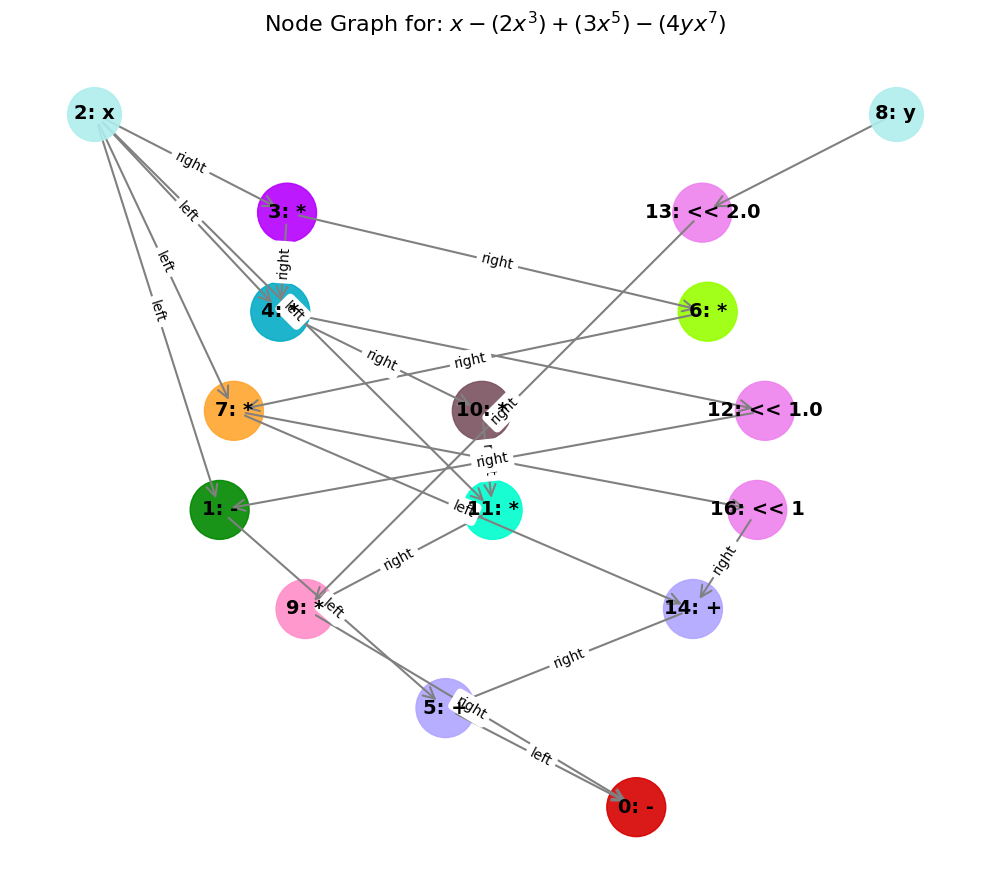

{2: 0, 8: 0, 3: 1, 13: 1, 4: 2, 6: 2, 10: 3, 12: 3, 7: 3, 11: 4, 1: 4, 16: 4, 9: 5, 14: 5, 5: 6, 0: 7}
{2: 0, 8: 0, 3: 1, 13: 1, 4: 2, 6: 2, 10: 3, 12: 3, 7: 3, 11: 4, 1: 4, 16: 4, 9: 5, 14: 5, 5: 6, 0: 7}


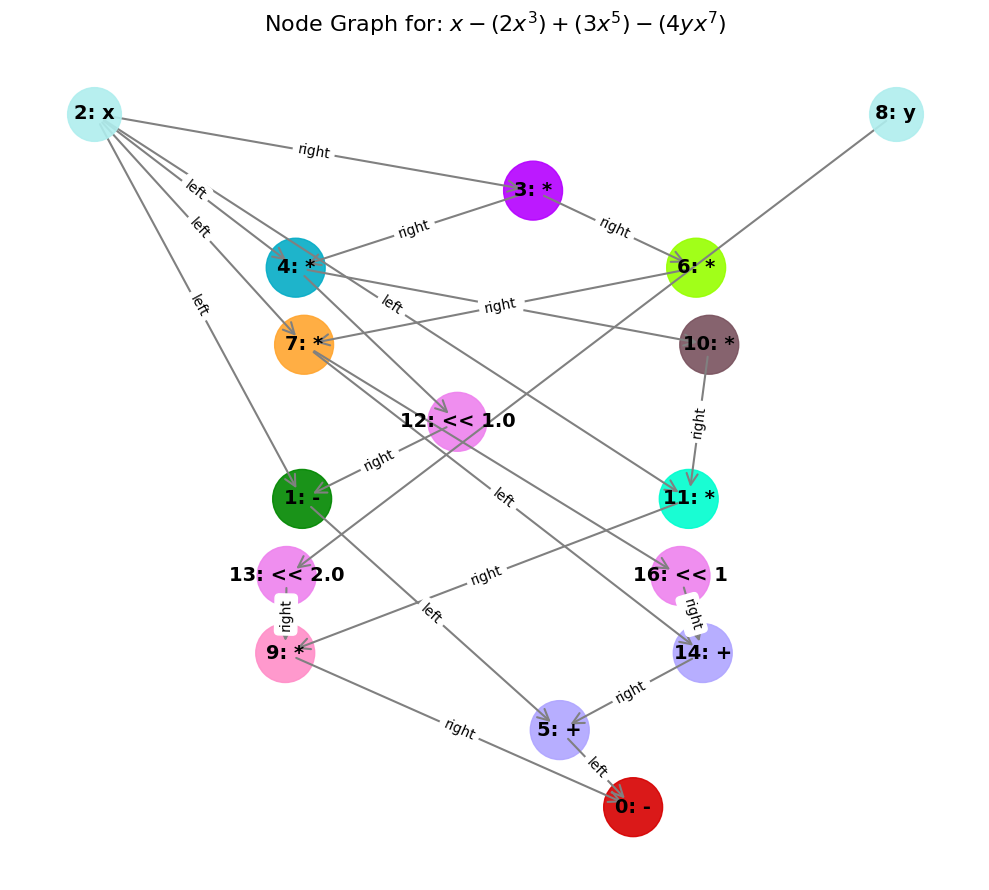

[[0], [1], [3], [4], [6], [7], [9], [10], [11], [14, 5]]


In [17]:


def split_into_dsp_stages(G, adjusted_levels, dsp_combos):
# Move DSP nodes in order to get DSPs to start at the same time
    split_stage_levels = dict(adjusted_levels)
    max_dsp_length = 0

    # all_nodes = []
    # for node, depth in adjusted_levels.items():
    #     if depth > 0:
    #         all_nodes.append(node)

    # print(all_nodes)
    last_dsp_nodes = []
    move_nodes_down = []

    frozen_nodes = set()
    count = 0

    level_num = 1

    while level_num <= max(split_stage_levels.values()):
        # print("MAX LEVEL: ", max(split_stage_levels.values()))
        # print("Sets are equal: ", set(G.nodes()) == frozen_nodes)

        nodes_at_this_level = [key for key, value in split_stage_levels.items() if value == level_num]
        # print("Nodes at this level: ", nodes_at_this_level)
        operation_set_this_level = {key for key in nodes_at_this_level if '<<' not in G.nodes[key]['label'] and '>>' not in G.nodes[key]['label']}

        
        for node in nodes_at_this_level:
            if ('<<' not in G.nodes[node]['label'] and '>>' not in G.nodes[node]['label']):
                # print("---------")
                # print("Node: ", node)
                # print("Depth of: ", level_num)
                # print("Level number: ", level_num)

                matching_dsp_list = [sublist for sublist in dsp_combos if sublist and sublist[0] == node]
                


                if matching_dsp_list:
                    matching_dsp_list = matching_dsp_list[0]
                    # print("DSP combo with this node as first: ", matching_dsp_list)

                    
                    # Freeze nodes if all other nodes on that level are the first nodes in a dsp combo

                    first_term_dsp_combos = {sublist[0] for sublist in dsp_combos if sublist}
                    # print("First terms are: ", first_term_dsp_combos)
                    # print("Operations on this level: ", operation_set_this_level)

                    # All nodes in this level are the first nodes in a dsp combo
                    all_present = operation_set_this_level.issubset(first_term_dsp_combos)
                    # print("They are all present: ", all_present)

                    # Also need to check that an out edge of one dsp combo does not point to the other dsp combo
                    other_nodes = list(operation_set_this_level - {node})
                    # print("Other nodes here: ", other_nodes ) 
                    dsp_of_node = [sublist for sublist in dsp_combos if sublist[0] == node][0]
                    
                    linked_to_same_level = False
                    if other_nodes:
                        for item in other_nodes:
                            dsps_same_line = [sublist for sublist in dsp_combos if sublist[0] == item]

                        # print("dsp same line: ", dsps_same_line)
                        
                        for item in dsps_same_line:
                            for k in item:
                                for m in list(G.out_edges(k)):
                                    for l in dsp_of_node:
                                        if m[1] == l:
                                            print(m)
                                            linked_to_same_level = True

                    #             print(m[1], dsp_of_node)

                    # if len(matching_dsp_list) > 0 and len(matching_dsp_list) > max_dsp_length:
                    #     max_dsp_length = len(matching_dsp_list)
                    # The - {matching_dsp_list[0]} is needed because, a DSP node can be on the same line as the beginning of a different DSP node combo
                    # print("Frozen node before: ", frozen_nodes)
                    # print("linked to the same level :", linked_to_same_level)
                    if all_present and not linked_to_same_level:
                        # print("Ancestors: ", nx.ancestors(G, matching_dsp_list[-1]) | {matching_dsp_list[-1]})


                        frozen_nodes.update(nx.ancestors(G, matching_dsp_list[-1]) | {matching_dsp_list[-1]})
                        # print("Froze nodes are: ", frozen_nodes)
                else:
                    continue

        ## At this point the frozen nodes contain DSP blocks and ancestors that should not be moved


        # print("After looping through all, frozen node: ", frozen_nodes)

        # Nodes on the next level which do not contain shifts
        #level_nodes = [k for k, v in split_stage_levels.items() if v == level_num and ('<<' not in G.nodes[k]['label'] and '>>' not in G.nodes[k]['label'])]
        #level_nodes = set(level_nodes)
        # print("Nodes on this level: ", operation_set_this_level)
        difference = operation_set_this_level - frozen_nodes
        # print("These nodes need to be moved: ", difference)
        # Check that other nodes with the same level are in the frozen node set
        if difference:

            descendants = set()
            for b in nodes_at_this_level:
                nodes_below = [key for key, value in split_stage_levels.items() if value >= split_stage_levels[b]]
                descendants.update(set(nodes_below))

            # Descendants will be moved down
            # Remove Frozen Nodes from descendants
            descendants -= frozen_nodes
            # print("List of descendants here: ", descendants)

            while any(split_stage_levels.get(x) == split_stage_levels[next(iter(difference))] for x in frozen_nodes):
                for item in descendants:
                    split_stage_levels[item] = split_stage_levels[item] + 1











            # for j in difference:
            #     print("On this level there are frozen node: ", any(split_stage_levels.get(x) == split_stage_levels[j] for x in frozen_nodes))
            #     print("DSP is on this level: ", split_stage_levels[j])



            #     # If node is on a level with frozen nodes then update node
            #     while any(split_stage_levels.get(x) == split_stage_levels[j] for x in frozen_nodes):
            #         split_stage_levels[j] = split_stage_levels[j] + 1
            #         print("New level for node: ", split_stage_levels[j])
            #         child = list(G.successors(j))
            #         child = child[0]
                    
            #         print("Child has level: ", split_stage_levels[child])

            #         if split_stage_levels[child] == split_stage_levels[j]:
            #             print("Node and child need be moved down")
            #             print(level_num)

            #         # But also need to check all following nodes
            #         # If child node has a level difference of 0, move all nodes of that level down by 1
            #         # Needs to loop all the way to the bottom of the graph
            #         following_node = j
            #         while G.out_degree(following_node) != 0:
                        
            #             child = list(G.successors(following_node))
            #             child = child[0]
            #             print("Child being checked: ", child)
            #             print("Child level: ", split_stage_levels[child])
            #             if split_stage_levels[child] <= split_stage_levels[following_node]:
            #                 print("Child and parent are on the same level")
            #                 split_stage_levels[child] = split_stage_levels[following_node] + 1
            #                 print("Node: ", child)
            #                 print("New level: ", split_stage_levels[child])
            #             following_node = child
        
            # frozen_nodes.update(difference)
        
        count += 1
        level_num += 1

    return G, split_stage_levels






def isolate_shift_nodes(G, split_shift_levels):
    divide_shift_levels = dict(split_shift_levels)
    shift_nodes = []


    for node in G.nodes():
        if ('<<' in G.nodes[node]['label'] or '>>' in G.nodes[node]['label']):
            shift_nodes.append(node)

    shift_nodes = sorted(shift_nodes, key=lambda x: divide_shift_levels[x])

    # print("Shift nodes are: ", shift_nodes)


    # For each shift node, need to find its child -> DSP combo child is in -> level of first node in that DSP combo

    # print(shift_nodes)
    for node in shift_nodes:
        # print("Shift Node: ", node)
        child = list(G.out_edges(node))
        child_node = child[0][1]
        # print("Child node: ", child_node)

        # equal_level_nodes =  [k for k, v in divide_shift_levels.items() if v == divide_shift_levels[child_node]]
        associated_combos = [sub for sub in dsp_combos if child_node in sub][0]
        first_node_in_stage = associated_combos[0]
        # print("Associated combo: ", node, associated_combos)


        equal_level_nodes =  [k for k, v in divide_shift_levels.items() if v == divide_shift_levels[node]]
        only_shift_nodes = all('<<' in G.nodes[node]['label'] or '>>' in G.nodes[node]['label'] for node in equal_level_nodes)
        # print(node, only_shift_nodes)
        
        #if not only_shift_nodes:
        divide_shift_levels[node] = divide_shift_levels[first_node_in_stage]

        # Node should go on the same level as the first node in the associated combo


    ## Puts the shift nodes on their own line
    ## After having moved shift nodes to the beginning, go through and move nodes on the same line as the shift down
    # print(set(split_shift_levels.values()))

    current_level = min(divide_shift_levels.values())
    max_level = max(divide_shift_levels.values())
    
    while current_level <= max_level:
        equal_level_nodes =  [k for k, v in divide_shift_levels.items() if v == current_level]
        # print("Nodes of equal level: ", equal_level_nodes)

        contains_shift_nodes = any('<<' in G.nodes[node]['label'] or '>>' in G.nodes[node]['label'] for node in equal_level_nodes)
        only_shift_nodes = all('<<' in G.nodes[node]['label'] or '>>' in G.nodes[node]['label'] for node in equal_level_nodes)
        
        # prev_level_nodes =  [k for k, v in divide_shift_levels.items() if v == current_level -1]
        # prev_only_shift_nodes = all('<<' in G.nodes[node]['label'] or '>>' in G.nodes[node]['label'] for node in prev_level_nodes)
        
        operation_nodes = []
        descendants = set()
        # print("Contains shift nodes: ", contains_shift_nodes)
        # print("Has only shift nodes: ", only_shift_nodes)
        if contains_shift_nodes and not only_shift_nodes:
            for node in G.nodes():
                if not ('<<' in G.nodes[node]['label'] or '>>' in G.nodes[node]['label']) and divide_shift_levels[node] == current_level:
                    operation_nodes.append(node)

            # print("Operations on that level: ", operation_nodes)
            nodes_below = [k for k, v in divide_shift_levels.items() if v > current_level]
            # print("Nodes below: ", nodes_below)
            # for p in operation_nodes:
            #     #print(divide_shift_levels[p])
            #     nodes_in_prev_level =  [k for k, v in divide_shift_levels.items() if v == current_level- 1]
            #     #print(nodes_in_prev_level)
            #     exclusively_shifts_before = all('<<' in G.nodes[node]['label'] or '>>' in G.nodes[node]['label'] for node in nodes_in_prev_level)
            #     if exclusively_shifts_before and ('<<' in G.nodes[p]['label'] or '>>' in G.nodes[p]['label']):
            #         operation_nodes.remove(p)
            #         print("Removed: ", p)

            # print(nodes_below)
            descendants.update(set(operation_nodes))
            descendants.update(set(nodes_below))
            # print("Operatio nodes are: ", operation_nodes)
            # for node in operation_nodes:
            #     # print(node)
            #     descendants.update(nx.descendants(G, node) | {node})

            # print("For level: ", current_level )
            # print("Descendants are: ", descendants)
        # print(operation_nodes)

            for item in descendants:
                divide_shift_levels[item] = divide_shift_levels[item] + 1

            max_level = max(divide_shift_levels.values())


        if only_shift_nodes:
            # Move all higher levels up by 1 to compress this level
            for node in divide_shift_levels:
                if divide_shift_levels[node] > current_level:
                    divide_shift_levels[node] -= 1
            max_level -= 1  
        else:
            current_level += 1 
        # current_level += 1


    # Add last part so that if for level n, level n+1 is only shift nodes, all nodes below are moved up by 1
    # current_level = min(divide_shift_levels.values())

    # while current_level <= max_level:
    #     equal_level_nodes =  [k for k, v in divide_shift_levels.items() if v == current_level]
    #     only_shift_nodes = all('<<' in G.nodes[node]['label'] or '>>' in G.nodes[node]['label'] for node in equal_level_nodes)

    #     next_level_nodes =  [k for k, v in divide_shift_levels.items() if v == current_level + 1]
    #     next_only_shift_nodes = all('<<' in G.nodes[node]['label'] or '>>' in G.nodes[node]['label'] for node in next_level_nodes)

    #     if only_shift_nodes and next_only_shift_nodes:
    #         nodes_below = [k for k, v in divide_shift_levels.items() if v > current_level]
    #         print(nodes_below)

    #         for j in nodes_below:
    #             divide_shift_levels[j] = divide_shift_levels[j] - 1
    #         print("YYES", current_level)

    #     max_level = max(divide_shift_levels.values())
    #     current_level += 1
        





    return divide_shift_levels




print("SPLIT HERE----------------------")
G_mod, split_stage_levels = split_into_dsp_stages(G_mod, adjusted_levels, dsp_combos)
print(dsp_combos)

GenerateTree(G_mod, user_input, specific_node_colors= make_color_assignments(dsp_combos), provided_levels = split_stage_levels)
print(split_stage_levels)

## Arrange all shift nodes in the level before the beginning of the DSP stage the child node belongs to, and then move all other nodes down

print(split_stage_levels)

split_shift_levels = isolate_shift_nodes(G_mod, split_stage_levels)
GenerateTree(G_mod, user_input, specific_node_colors= make_color_assignments(dsp_combos), provided_levels = split_shift_levels)

print(dsp_combos)


### Precision assessment

In [18]:
import numpy as np
import fixedpoint as fp
import matplotlib.pyplot as plt
import operator

def end_dsp_block(node, dsp_combos):

    for combo in dsp_combos:
        last_node = combo[-1]
        
        if node == last_node:
            return True
    
    return False


def last_node_in_dsp(G, node, dsp_combos):
    for combo in dsp_combos:
        operations = [G.nodes[s]['label'] for s in combo]
        if '*' in operations:
            
            #print(operations)
            if node == combo[-1]:
                print("End of DSP with mult")
                return True
        
    return False


def mult_postadder_use(G, node, dsp_combos):
    print(dsp_combos)
    for combo in dsp_combos:
        if len(combo) > 1:
            if last_node_in_dsp(G, node, dsp_combos) and G.nodes[combo[-2]]['label'] == '*':
                print('End of DSP Block with multiplier and poastadder')
                # print(G.nodes[combo[-2]]['label'])
                # print(combo[-1])
                # if G.nodes[combo[-2]]['label'] == '*' and node == combo[-1]:

                return True
    
    return False



print(mult_postadder_use(G_mod, 15, dsp_combos))

def twos_complement_to_int(val_str):
    val = int(val_str, 2)
    bits = len(val_str)
    if (val & (1 << (bits - 1))) != 0: 
        val = val - (1 << bits)        
    return val                        

def int_to_twos_complement(num, bits):
    if num >= 0:
        return bin(num)[2:].zfill(bits)
    return bin((1 << bits) + num)[2:]

def dsp_mult(a, b):
    a_int = twos_complement_to_int(a)
    b_int = twos_complement_to_int(b)

    product = a_int * b_int

    product_bin = int_to_twos_complement(product, len(a) + len(b))
    print(len(product_bin))

    if len(product_bin) < 43:
        sign_bit = product_bin[0]
        pad_len = 43 - len(product_bin)
        product_bin = (sign_bit * pad_len) + product_bin

    if len(product_bin) >= 43:
        final_product = product_bin[:43]
    else:
        final_product = product_bin

    return final_product

def dsp_add(a, b):

    a_int = twos_complement_to_int(a)
    b_int = twos_complement_to_int(b)

    sum = a_int + b_int
    sum_bin = int_to_twos_complement(sum, max(len(a), len(b)) + 1)

    return sum_bin

def dsp_subtract(a, b):

    a_int = twos_complement_to_int(a)
    b_int = twos_complement_to_int(b)

    diff = a_int - b_int
    diff_bin = int_to_twos_complement(diff, max(len(a), len(b)) + 1)

    return diff_bin


def arithmetic_shift(val_str, shifts):
    val = twos_complement_to_int(val_str)

    if shifts > 0:
        shifted = val << shifts
    elif shifts < 0:
        shifted = val >> -shifts

    shifted_bin = int_to_twos_complement(shifted, len(val_str))

    if shifted_bin[0] =='b':
        shifted_bin = shifted_bin[1:]
    
    return shifted_bin


# Starting nodes
print(new_levels)



converted_node_results = {}

def initial_values(new_levels, quantised):

    if quantised:

        values = ["00100000000000", "00110000000000", "01000000000000"]
    else:
        values = [2, 3, 4]


    node_results = {}

    starting_nodes = [node for node, level in new_levels.items() if level == 0]

    print("Starting nodes: ", starting_nodes)    

    vars = dict(zip(starting_nodes, values))

    for n in starting_nodes:
        node_results[n] = vars[n]

    return node_results



def calculate_expression(G, new_levels, quantised = False, m = 10, n = 10):

    ops = {
        '+': operator.add,
        '-': operator.sub,
        '*': operator.mul
    }
    
    node_results = initial_values(new_levels, quantised)

    if quantised:
        number_node_results = initial_values(new_levels, quantised = False)
    else:
        number_node_results = {}
    print(number_node_results)

    # First part is using the graph to compute a result with floating point


    for th in range(1, max(new_levels.values()) + 1):
        
        th_level = [node for node, level in new_levels.items() if level == th]

        for item in th_level:
            print("Node: ", item)
            truncate_multiplication = False

            preds = list(G.predecessors(item))

            operation = G.nodes[item]['label']

            print("operation: ", operation)


            if operation in ('+', '-', '*'):

                right = [u for u, v, attr in G.in_edges(item, data=True) if attr['label'] == 'right']
                left = [u for u, v, attr in G.in_edges(item, data=True) if attr['label'] == 'left']
            
                if operation == '*' and len(preds) == 1:

                    if quantised:
                        calculation = dsp_mult(node_results[preds[0]], node_results[preds[0]])
                        number_calculation = number_node_results[preds[0]]**2

                        if last_node_in_dsp(G_mod, item, dsp_combos):
                            truncate_multiplication = True
                        
                        #calculation = fp.FixedPoint(node_results[preds[0]]**2, signed = True, m = m, n = n, str_base = 2)
                    else:
                        calculation = node_results[preds[0]]**2


                    print("Calculation power: ", calculation)

                else:

                    left_value = node_results[left[0]]
                    right_value = node_results[right[0]]

                    print(left_value, right_value)

                    if quantised:
                        if operation == '*':
                            calculation = dsp_mult(left_value, right_value)
                        elif operation =='+':

                            if mult_postadder_use(G_mod, item, dsp_combos):
                                print("here")
                                print(left_value)
                                left_value = left_value.ljust(len(left_value) + 10, '0')
                                print("Extended left: ", left_value)

                            calculation = dsp_add(left_value, right_value)

                        elif operation == '-':
                            if mult_postadder_use(G_mod, item, dsp_combos):
                                print("here")
                                print(left_value)
                                left_value = left_value.ljust(len(left_value) + 10, '0')
                                print("Extended left: ", left_value)

                            calculation = dsp_subtract(left_value, right_value)
                        #calculation = fp.FixedPoint(ops[operation](left_value, right_value), signed = True, m = m, n = n, str_base = 2)
                        
                        #End of DSP block with a multiplier, truncate 2n frac bits
                        if last_node_in_dsp(G_mod, item, dsp_combos):
                            truncate_multiplication = True

                        left_value = number_node_results[left[0]]
                        right_value = number_node_results[right[0]]
                        number_calculation = ops[operation](left_value, right_value)
                    else:
                        calculation = ops[operation](left_value, right_value)

                    print(calculation)

            elif '<<' in operation or'>>' in operation:
                match = re.search(r'(<<|>>)\s*(\d+)', operation)
                direction, exponent = match.groups()

                if direction == '>>':
                    exponent = - int(exponent)

                else:
                    exponent = int(exponent)
                
                if quantised:
                    print("To shift: ", node_results[preds[0]])
                    calculation = arithmetic_shift(node_results[preds[0]], exponent)
                    # q_val = fp.FixedPoint(node_results[preds[0]], signed = True, m = m, n = n, str_base = 2)
                    # q_shifted = q_val << exponent
                    # calculation = fp.FixedPoint(q_shifted, signed = True, m = m, n = n, str_base = 2)
                    # print(float(q_val))
                    # print(q_val)

                    number_calculation = number_node_results[preds[0]] * (2 ** exponent)


                else:
                    calculation = node_results[preds[0]] * (2 ** exponent)

                print(calculation)

            
            if quantised:
                if truncate_multiplication:
                    # Multiplication was used meaning that 2n fractional bits have to be cut down to n fractional bits
                    print("We need to truncate here")
                    print(calculation[:-10])
                    calculation = calculation[:-10]

            

            
            if quantised:
                node_results[item] = str(calculation)

                number_node_results[item] = float(number_calculation)
            else:
                print(float(calculation))
                node_results[item] = float(calculation)

            if quantised:
                for u,v in node_results.items():
                    converted_node_results[item] = float(fp.FixedPoint("0b" + str(v), signed = True, m = len(v) - 10, n = 10, str_base = 2))

            print(node_results)
            print(converted_node_results)
            print(number_node_results)

    print(node_results[0])

    if quantised:
        v = node_results[0]
        print(float(fp.FixedPoint("0b" + str(v), signed = True, m = len(v) - 10, n = 10, str_base = 2)))


calculate_expression(G_mod, new_levels, quantised = True, m = 10, n = 2)

## Next step is to do the same calculation but the fixed point arithmetic

x = np.array([2])
y = np.array([3])
z = np.array([4])
result = eval(user_input.replace('^', '**'))      
print("Numpy calculation: ", result[0])



[[0], [1], [3], [4], [6], [7], [9], [10], [11], [14, 5]]
False


NameError: name 'new_levels' is not defined

In [ ]:
import fixedpoint as fp

# Apply truncation: rounding='down'
a = fp.FixedPoint(12.11234, signed = True, m = 5, n = 3, str_base = 2)
b = fp.FixedPoint(10.13243, signed = True, m = 5, n = 3, str_base = 2)

print(float(a), float(b))
c = float(a)*float(b)
print(float(c))
print(a.qformat)
print(12.11234 * 10.13243)
print(float(a) * float(b))
print(str(a))

x = fp.FixedPoint(c, signed = True, m = 4, n = 3, rounding = "down", overflow = "clamp", overflow_alert= 'ignore')

print(float(x))



# Beginning value is specified to a length of bits
# Operation inside DSP node is done with the maximum width that a DSP block can handle
# After last DSP node, result is truncated (rounding = down) to set Qm.n format
ops = {
    '+': operator.add,
    '-': operator.sub,
    '*': operator.mul
}


print("starting here")
a = fp.FixedPoint(4.23, signed = True, m = 5, n = 5, str_base = 2)
b = fp.FixedPoint(3.69, signed = True, m = 5, n = 5, str_base = 2)
print(float(a), float(b))

c = fp.FixedPoint(float(a) + float(b), signed = True, m = 6, n = 3, str_base = 2, rounding = "down")
print(str(c))
c = fp.FixedPoint(ops['+'](float(a), float(b)), signed = True, m = 6, n = 3, str_base = 2, rounding = "down")

print(str(c))
c_trunc = fp.FixedPoint(float(c), signed = True, m = 6, n = 0, str_base = 2, rounding = "down")
print(str(c_trunc))
print("Accurate: ", float(4.23 + 3.69))
print(float(c))


d = fp.FixedPoint(-4.23, signed=True, m=10, n=5, str_base = 2)
print("Original:", float(d), str(d))

# Step 2: Shift right by 3 bits (equivalent to dividing by 8)
d_shifted = d >> 3  # or d << -3
print("Shifted :", float(d_shifted), str(d_shifted))

# Step 3: Convert to Q10.5 explicitly
d_truncated = fp.FixedPoint(d_shifted, signed=True, m=10, n=5, rounding='trunc', overflow='clamp')
print("Final   :", float(d_truncated), str(d_truncated))




print(end_dsp_block(11, dsp_combos))



In [ ]:
def twos_complement_to_int(val_str):
    val = int(val_str, 2)
    bits = len(val_str)
    if (val & (1 << (bits - 1))) != 0: 
        val = val - (1 << bits)        
    return val                        

def int_to_twos_complement(num, bits):
    if num >= 0:
        return bin(num)[2:].zfill(bits)
    return bin((1 << bits) + num)[2:]


def arithmetic_shift(val_str, shifts):
    val = twos_complement_to_int(val_str)

    if shifts > 0:
        shifted = val << shifts
    elif shifts < 0:
        shifted = val >> -shifts

    shifted_bin = int_to_twos_complement(shifted, len(val_str))

    if shifted_bin[0] =='b':
        shifted_bin = shifted_bin[1:]
    
    return shifted_bin


def dsp_mult(a, b):
    a_int = twos_complement_to_int(a)
    b_int = twos_complement_to_int(b)

    product = a_int * b_int

    product_bin = int_to_twos_complement(product, len(a) + len(b))
    print(len(product_bin))
    # Extend to 24 bits
    if len(product_bin) < 43:
        sign_bit = product_bin[0]
        pad_len = 43 - len(product_bin)
        product_bin = (sign_bit * pad_len) + product_bin

    if len(product_bin) >= 43:
        msb24 = product_bin[:43]
    else:
        msb24 = product_bin

    return msb24

def dsp_add(a, b):

    a_int = twos_complement_to_int(a)
    b_int = twos_complement_to_int(b)

    sum = a_int + b_int
    sum_bin = int_to_twos_complement(sum, max(len(a), len(b)) + 1)

    return sum_bin

def dsp_subtract(a, b):

    a_int = twos_complement_to_int(a)
    b_int = twos_complement_to_int(b)

    diff = a_int - b_int
    diff_bin = int_to_twos_complement(diff, max(len(a), len(b)) + 1)

    return diff_bin




a = "0001101101010101000" 
b = "0100101010101010000011" 
n = 4
print(len(a), len(b))

a_float = float(fp.FixedPoint("0b" + str(a), signed = True, m = len(a) - n, n = n))
b_float = float(fp.FixedPoint("0b" + str(b), signed = True, m = len(b) - n, n = n))

print( float(fp.FixedPoint("0b" + str(a), signed = True, m = len(a) - n, n = n)))
print( float(fp.FixedPoint("0b" + str(b), signed = True, m = len(b) - n, n = n)))


msb24 = dsp_mult(a, b) 
print(f"Product: {msb24}")
print(a_float * b_float)
print( float(fp.FixedPoint("0b" + str(msb24), signed = True, m = 43 - 2*n, n = 2*n)))
dsp_add(a, b)
print("Addition: ", float(fp.FixedPoint("0b" + str(dsp_add(a, b)), signed = True, m = max(len(a), len(b)) + 1 - n, n = n )))
print(a_float + b_float)


dsp_subtract(a, b)
print("Subtraction: ", float(fp.FixedPoint("0b" + str(dsp_subtract(a, b)), signed = True, m = max(len(a), len(b)) + 1 - n, n = n)))
print(a_float - b_float)

shifted = arithmetic_shift(b, -8)
print(shifted)
print(len(shifted))
print("Subtraction: ", float(fp.FixedPoint("0b" + str(shifted), signed = True, m = len(b) - n, n = n)))


# Extra Code

In [ ]:

def test_pos(graph, polynomial_str, pos, specific_node_colors = None):

    if specific_node_colors is None:
        specific_node_colors = {}

    #print(pos)

    plt.figure(figsize=(18, 12))

    #Divide up the nodes
    operation_nodes = [n for n in graph.nodes() if graph.nodes[n].get('type') == 'operation']
    value_nodes = [n for n in graph.nodes() if graph.nodes[n].get('type') == 'value']

    operation_node_colors = [specific_node_colors.get(node, 'violet') for node in operation_nodes]


    edges = nx.draw_networkx_edges(graph, pos, arrows=True, arrowstyle='->', arrowsize=20, width=1.5, edge_color='gray')
    for edge in edges:
        edge.set_zorder(2)

    nodes = nx.draw_networkx_nodes(graph, pos, nodelist=operation_nodes, node_size=1800, node_color = operation_node_colors, alpha=0.9)
    nodes.set_zorder(1)

    nodes = nx.draw_networkx_nodes(graph, pos, nodelist=value_nodes, node_size=1500, node_color='paleturquoise', alpha=0.9)
    nodes.set_zorder(1)

    edge_labels = nx.get_edge_attributes(graph, 'label')

    # Draw edge labels
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)


    node_id_labels = {node: str(node) for node in graph.nodes()}
    #nx.draw_networkx_labels(graph, pos, labels=node_id_labels, font_size=12, font_weight='bold')
    # nx.draw_networkx_labels(graph, pos, labels=node_labels, font_size=14, font_weight='bold')

    labels = {}
    for node in graph.nodes():
        attr_value = graph.nodes[node].get('label', '')
        labels[node] = f"{node}: {attr_value}"

    graph_labels = nx.draw_networkx_labels(graph, pos, labels=labels, font_size=14, font_weight='bold')
    for text in graph_labels.values():
        text.set_zorder(3)  # labels on top


    plt.title(f"Node Graph for: ${(polynomial_str.replace('**', '^')).replace('*', '')}$", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show() 



initial_pos = GenerateTree(G_mod, user_input).custom_layout(G_mod)





In [ ]:
test_pos(G_mod, user_input, initial_pos, specific_node_colors= make_color_assignments(DSPSearch.Solver))



In [ ]:
print(new_pos)

GenerateTree(G_mod, user_input, specific_node_colors= make_color_assignments(DSPSearch.Solver), pos = new_pos)


### Optimise x values


In [ ]:
import networkx as nx
import numpy as np
from scipy.optimize import minimize, LinearConstraint
from collections import defaultdict

def calculate_stress(x_coords, G, nodes, initial_y):
    stress = 0.0
    pos_new = {node: (x_coords[i], initial_y[i]) for i, node in enumerate(nodes)}
    
    # Stress term (target distances)
    for u, v in G.edges():
        dx = pos_new[u][0] - pos_new[v][0]
        dy = pos_new[u][1] - pos_new[v][1]
        current_length = np.sqrt(dx**2 + dy**2)
        desired_length = 1.0  # We aim for uniform edge lengths
        stress += (current_length - desired_length)**2
    
    # Node distribution term (avoid overlaps)
    x_sorted = np.sort(x_coords)
    n = len(nodes)
    for i in range(1, n):
        stress += 10.0 / max(0.1, x_sorted[i] - x_sorted[i-1])**2
    
    return stress

def optimize_coordinates(G, pos):
    nodes = list(G.nodes())
    n = len(nodes)
    node_index = {node: i for i, node in enumerate(nodes)}
    
    # Prepare initial coordinates
    initial_x = np.array([pos[node][0] for node in nodes])
    initial_y = np.array([pos[node][1] for node in nodes])
    
    # Constraints to preserve y-ordering
    constraints = []
    for layer in get_y_layers(pos):
        if len(layer) > 1:
            for i in range(len(layer)-1):
                u = node_index[layer[i]]
                v = node_index[layer[i+1]]
                # Keep original left-to-right order within y-layers
                constraints.append(LinearConstraint(
                    A=np.eye(n)[u] - np.eye(n)[v],
                    lb=0.1, ub=np.inf  # u should be to the left of v
                ))
    
    # Optimize using the external objective function
    res = minimize(
        lambda x: calculate_stress(x, G, nodes, initial_y),
        initial_x,
        method='SLSQP',
        constraints=constraints,
        options={'maxiter': 1000}
    )
    
    optimized_x = res.x
    optimized_pos = {node: (optimized_x[i], initial_y[i]) for i, node in enumerate(nodes)}
    
    return optimized_pos

def get_y_layers(pos):
    y_groups = defaultdict(list)
    for node, (x, y) in pos.items():
        y_groups[round(y, 3)].append(node)
    
    # Sort nodes within each y-layer by their original x-coordinate
    for y in y_groups:
        y_groups[y].sort(key=lambda n: pos[n][0])
    
    return [nodes for y, nodes in sorted(y_groups.items())]




# initial_pos = GenerateTree(G_mod, user_input).custom_layout(G_mod)

# print(initial_pos)

# optimised_pos = optimize_coordinates(G_mod, initial_pos)
# optimised_pos